<a href="https://colab.research.google.com/github/chuan1215/DLI_GroupAG/blob/main/LauYongFeng_ANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [13]:
import pandas as pd

data_path = "/content/drive/MyDrive/Colab Notebooks/dataset_phishing.csv"
df = pd.read_csv(data_path)

print("Dataset shape:", df.shape)
df.head()

Dataset shape: (11430, 89)


,url,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,...,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
0,http://www.crestonwood.com/router.php,37,19,0,3,0,0,0,0,0,...,0,1,0,45,-1,0,1,1,4,legitimate
1,http://shadetreetechnology.com/V4/validation/a...,77,23,1,1,0,0,0,0,0,...,1,0,0,77,5767,0,0,1,2,phishing
2,https://support-appleld.com.secureupdate.duila...,126,50,1,4,1,0,1,2,0,...,1,0,0,14,4004,5828815,0,1,0,phishing
3,http://rgipt.ac.in,18,11,0,2,0,0,0,0,0,...,1,0,0,62,-1,107721,0,0,3,legitimate
4,http://www.iracing.com/tracks/gateway-motorspo...,55,15,0,2,2,0,0,0,0,...,0,1,0,224,8175,8725,0,0,6,legitimate


In [14]:
# Drop rows with missing values
df.dropna(inplace=True)
print("After dropping NA:", df.shape)

# Check if there are any categorical values that need encoding
print("Data types:\n", df.dtypes)

# Identify the label column (based on your output, it's likely 'status')
if 'class' in df.columns:
    df.rename(columns={'class': 'label'}, inplace=True)
elif 'status' in df.columns:
    df.rename(columns={'status': 'label'}, inplace=True)
else:
    raise KeyError("No target label column found. Please ensure the dataset has a 'class' or 'status' column.")

# Drop non-numeric and non-informative columns like 'url'
df.drop(columns=['url'], inplace=True, errors='ignore')

# Convert label column to binary (e.g., 'phishing' = 1, 'legitimate' = 0)
df['label'] = df['label'].map({'phishing': 1, 'legitimate': 0})

After dropping NA: (11430, 89)
Data types:
 url                object
length_url          int64
length_hostname     int64
ip                  int64
nb_dots             int64
                    ...  
web_traffic         int64
dns_record          int64
google_index        int64
page_rank           int64
status             object
Length: 89, dtype: object


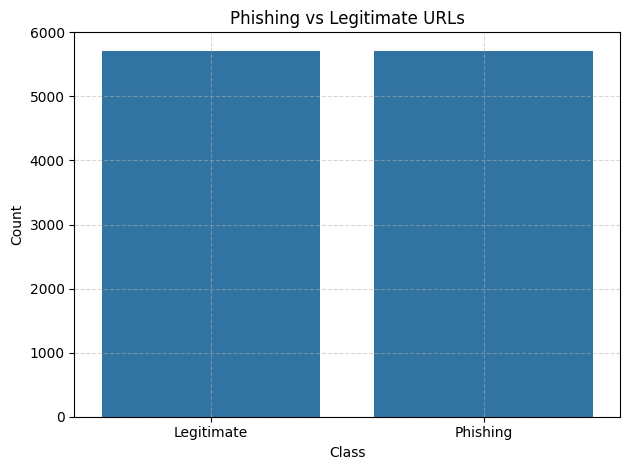

In [15]:
sns.countplot(data=df, x='label')
plt.title('Phishing vs Legitimate URLs')
plt.xticks([0, 1], ['Legitimate', 'Phishing'])
plt.xlabel('Class')
plt.ylabel('Count')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Separate features and target
X = df.drop(columns=['label'])
y = df['label']

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib

# Check class imbalance
unique_classes, class_counts = np.unique(y_train, return_counts=True)
class_weights = 'balanced' if max(class_counts) / min(class_counts) > 1.5 else None
print("[INFO] Class weight setting:", class_weights)

# Define the ANN model
ann_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid') # Output layer for binary classification
])

# Compile the ANN model
ann_model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

# Train the ANN model
history = ann_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the ANN model
loss, accuracy = ann_model.evaluate(X_test, y_test, verbose=0)
print("\nAccuracy:", accuracy)

# Predictions
y_pred_prob = ann_model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype("int32")

print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))
# Measure prediction runtime for one batch
start = time.time()
_ = ann_model.predict(X_test, verbose=0)
end = time.time()
inference_time = end - start
print("Inference Time (seconds):", round(inference_time, 4))

[INFO] Class weight setting: None
Epoch 1/50
229/229 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8138 - loss: 0.4054 - val_accuracy: 0.9393 - val_loss: 0.1565
Epoch 2/50
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9402 - loss: 0.1644 - val_accuracy: 0.9497 - val_loss: 0.1426
Epoch 3/50
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9514 - loss: 0.1407 - val_accuracy: 0.9552 - val_loss: 0.1409
Epoch 4/50
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9495 - loss: 0.1341 - val_accuracy: 0.9535 - val_loss: 0.1335
Epoch 5/50
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9571 - loss: 0.1235 - val_accuracy: 0.9546 - val_loss: 0.1289
Epoch 6/50
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9621 - loss: 0.1101 - val_accuracy: 0.9552 - val_loss: 0.1274
Epoch 7/50
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9622 - loss: 0.1003 - val_accuracy: 0.9552 - val_loss: 0.1252
Epoch 8/50
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9636

Model Parameters

In [22]:
params = ann_model.count_params()
print("Total Parameters:", params)

Total Parameters: 19585


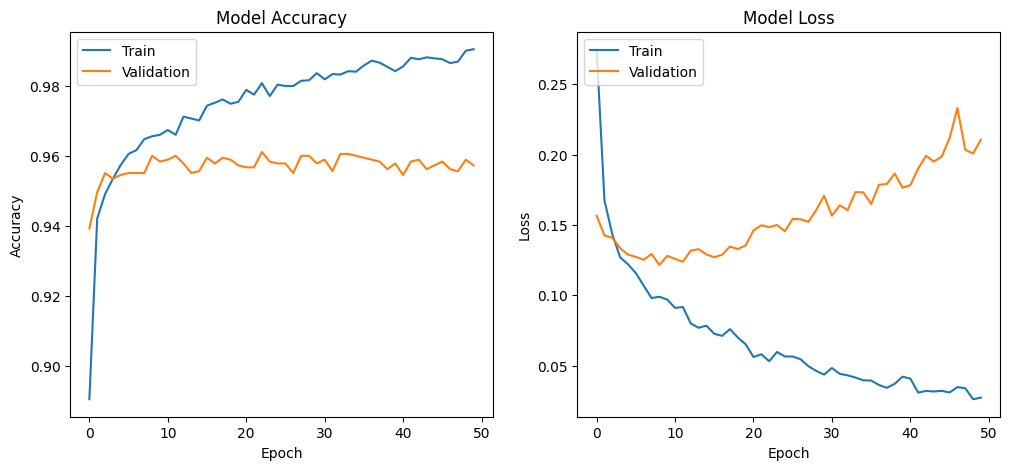

In [21]:
# Plot training history (optional)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

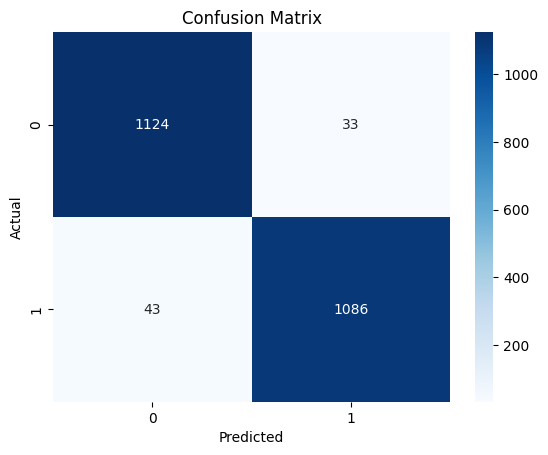

In [23]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


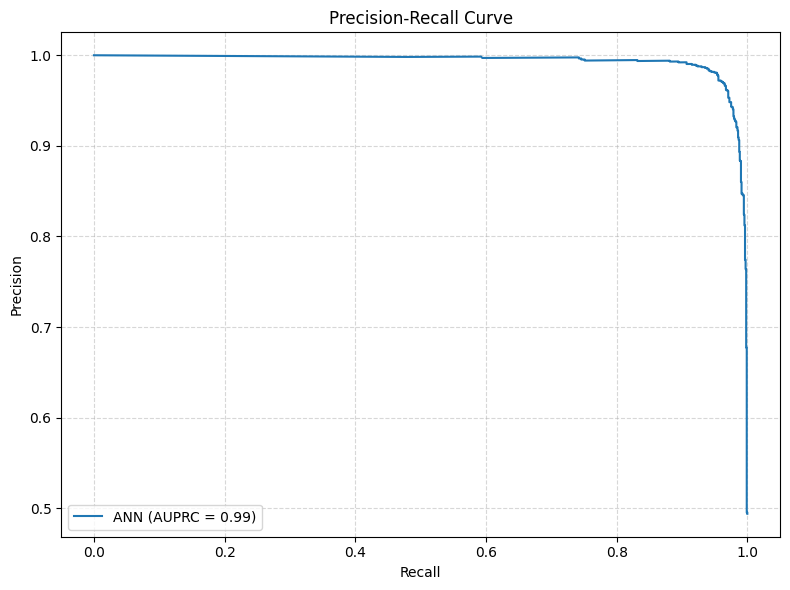

In [24]:
from sklearn.metrics import precision_recall_curve, auc

# Get precision and recall values for the ANN model
y_scores_ann = ann_model.predict(X_test).ravel()  # Probability of the positive class
precision_ann, recall_ann, _ = precision_recall_curve(y_test, y_scores_ann)

# Calculate the Area Under the PR Curve (AUPRC)
auprc_ann = auc(recall_ann, precision_ann)

# Plot the PR curve
plt.figure(figsize=(8, 6))
plt.plot(recall_ann, precision_ann, label=f'ANN (AUPRC = {auprc_ann:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


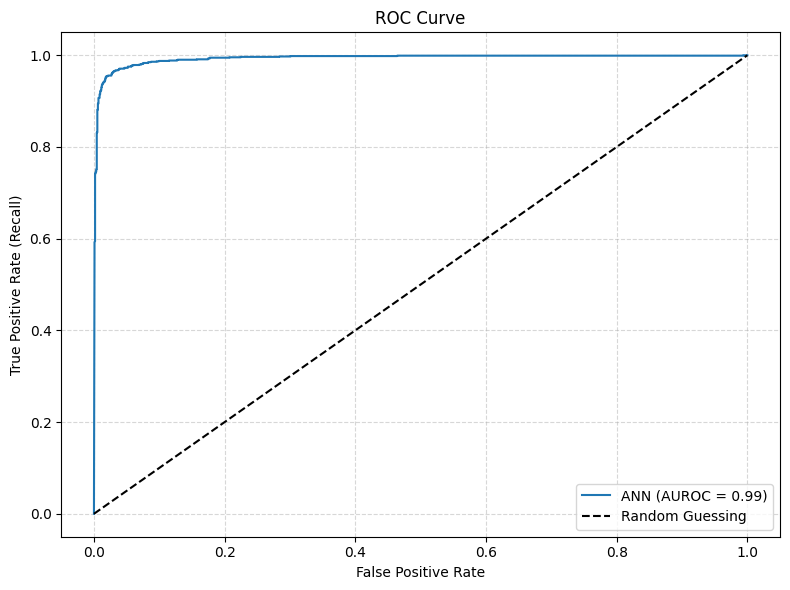

In [25]:
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities for the positive class
y_scores_ann = ann_model.predict(X_test).ravel()

# Calculate ROC curve
fpr_ann, tpr_ann, _ = roc_curve(y_test, y_scores_ann)

# Calculate Area Under the ROC Curve (AUROC)
auroc_ann = auc(fpr_ann, tpr_ann)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_ann, tpr_ann, label=f'ANN (AUROC = {auroc_ann:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()